In [69]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [4]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [5]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [6]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [7]:
vectorizer_bigram = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b", ngram_range=(2, 2))
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bigram = vectorizer_bigram.fit_transform(list(s)).toarray()
df_bigram = pd.DataFrame(data = X_bigram, columns = vectorizer_bigram.get_feature_names())

In [8]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Jaccard-bigram'], test_size = 0.2) 

In [9]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [10]:
X_train = dict()
X_train['stack_1'] = df_bigram.loc[indexes_train_1].values
X_train['stack_2'] = df_bigram.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bigram.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bigram.loc[indexes_validation_2].values

In [11]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [12]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

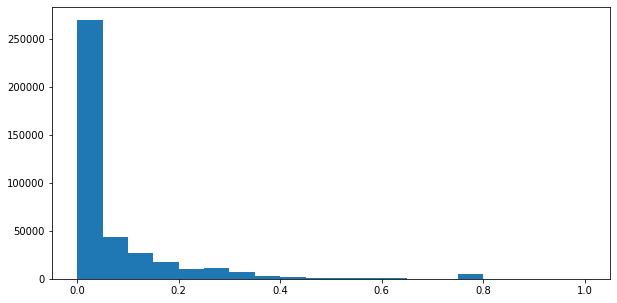

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

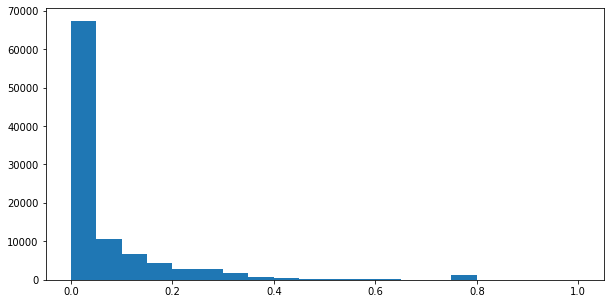

In [14]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [15]:
'Number of hash tables functions' 
m = 64

In [16]:
'Number of bits per hash function' 
b = 16

In [17]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [18]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'sigmoid'))
x.add(Dense(1024, activation = 'sigmoid'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [19]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3027)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3027)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         9349120     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [20]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 22s 26ms/step - loss: -0.2252 - manh_dist_loss: 0.0251 - abs_vect_loss: -0.9756 - abs_vect_1_loss: -0.9767 - manh_dist_rmse: 0.1583 - manh_dist_mae: 0.0754 - val_loss: -0.2384 - val_manh_dist_loss: 0.0115 - val_abs_vect_loss: -0.9880 - val_abs_vect_1_loss: -0.9883 - val_manh_dist_rmse: 0.1071 - val_manh_dist_mae: 0.0563
Epoch 2/20
781/781 [==============================] - 18s 23ms/step - loss: -0.2401 - manh_dist_loss: 0.0100 - abs_vect_loss: -0.9903 - abs_vect_1_loss: -0.9906 - manh_dist_rmse: 0.1000 - manh_dist_mae: 0.0526 - val_loss: -0.2411 - val_manh_dist_loss: 0.0092 - val_abs_vect_loss: -0.9917 - val_abs_vect_1_loss: -0.9920 - val_manh_dist_rmse: 0.0957 - val_manh_dist_mae: 0.0501
Epoch 3/20
781/781 [==============================] - 18s 23ms/step - loss: -0.2431 - manh_dist_loss: 0.0069 - abs_vect_loss: -0.9931 - abs_vect_1_loss: -0.9933 - manh_dist_rmse: 0.0833 - manh_dist_mae: 0.0441 - val_loss: -0.2443 - val_manh_dist_lo

# 3. Model Evaluation

In [21]:
del X_train

In [22]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{Baseline}$

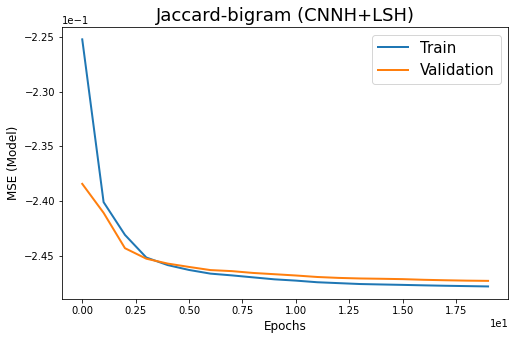

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('Jaccard-bigram (CNNH+LSH)', fontsize = 18)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of Similarity preserving loss

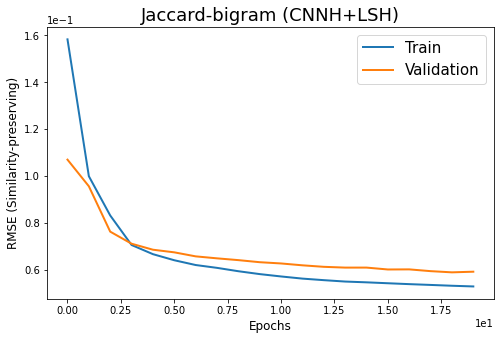

In [24]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Jaccard-bigram (CNNH+LSH)', fontsize = 18)
plt.ylabel('RMSE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

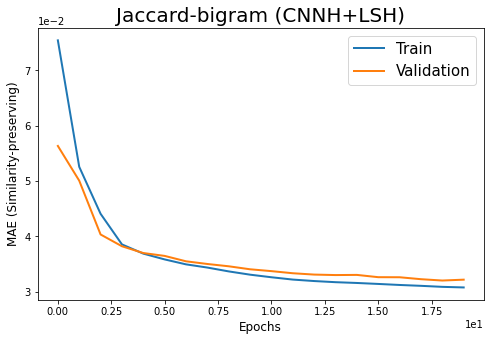

In [25]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Jaccard-bigram (CNNH+LSH)', fontsize = 20)
plt.ylabel('MAE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [26]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [27]:
np.around(predictions[0][:50],3) 

array([0.38 , 0.061, 0.06 , 0.007, 0.004, 0.278, 0.032, 0.029, 0.008,
       0.01 , 0.095, 0.001, 0.299, 0.093, 0.02 , 0.01 , 0.001, 0.082,
       0.003, 0.028, 0.004, 0.02 , 0.048, 0.093, 0.029, 0.006, 0.001,
       0.003, 0.001, 0.004, 0.012, 0.166, 0.162, 0.036, 0.001, 0.006,
       0.002, 0.075, 0.08 , 0.063, 0.002, 0.001, 0.003, 0.006, 0.009,
       0.002, 0.042, 0.024, 0.011, 0.064], dtype=float32)

In [28]:
np.around(Y_validation[:50],3) 

array([0.286, 0.136, 0.   , 0.   , 0.   , 0.24 , 0.   , 0.034, 0.   ,
       0.   , 0.192, 0.   , 0.292, 0.179, 0.   , 0.053, 0.   , 0.   ,
       0.   , 0.091, 0.   , 0.   , 0.   , 0.207, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.182, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.057, 0.024, 0.   , 0.   , 0.   , 0.   , 0.091,
       0.   , 0.   , 0.   , 0.   , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

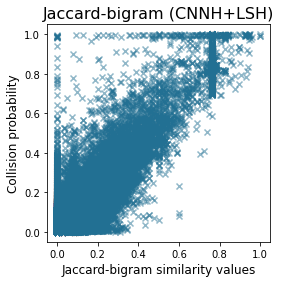

In [29]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Jaccard-bigram (CNNH+LSH)', fontsize = 16)
plt.xlabel("Jaccard-bigram similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Baseline/Jaccard-bigram-correlation', bbox_inches='tight')
plt.show()

In [30]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.7330229720550689

In [31]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.5998148723529646

## 3.3. Approximate Hamming Evaluation

In [32]:
output_layer = 2
model.layers[output_layer]

In [33]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [34]:
intermediate_model.save('Models/model-baseline.model')

INFO:tensorflow:Assets written to: Models/model-baseline.model/assets


In [35]:
#intermediate_model = keras.models.load_model('Models/model-baseline.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [36]:
'First 64 bits'
intermediate_model.predict(df_bigram.iloc[[10]])[0][:64]

array([ 1.        ,  0.9974105 ,  1.        , -1.        ,  0.99678206,
       -1.        , -1.        ,  1.        , -1.        ,  1.        ,
       -1.        , -1.        ,  1.        ,  1.        ,  0.99819213,
       -1.        ,  1.        ,  1.        , -0.9999939 , -0.9999997 ,
       -1.        , -0.9999995 , -1.        ,  0.99999845, -1.        ,
        1.        ,  1.        ,  1.        ,  1.        , -1.        ,
       -0.99999785, -1.        ,  0.97776866, -1.        , -1.        ,
       -1.        ,  1.        , -0.9969814 , -1.        , -1.        ,
       -0.99473447, -0.9998287 , -1.        ,  1.        , -1.        ,
        1.        , -1.        , -1.        ,  1.        ,  0.99737126,
       -0.999967  ,  1.        , -1.        ,  1.        ,  1.        ,
       -1.        , -1.        , -1.        ,  1.        ,  1.        ,
       -1.        , -0.96243423,  1.        ,  1.        ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [37]:
hash_vectors = intermediate_model.predict(df_bigram)

In [38]:
np.mean(np.abs(hash_vectors))

0.996134

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [39]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.731111328125

### 3.3.4. Comparison between approximate hamming and real hamming

In [40]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

In [41]:
df_hamming

,embedding_stack_1,embedding_stack_2,hamming
0,"[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, ...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, ...",0.234375
1,"[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, ...",0.000000
2,"[-1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, ...","[-1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1...",0.000000
3,"[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1...",0.000000
4,"[1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1,...","[-1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, ...",0.000000
...,...,...,...
99895,"[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, ...","[-1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, ...",0.000000
99896,"[1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, ...",0.000000
99897,"[-1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, ...","[1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1,...",0.015625
99898,"[-1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, ...","[1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, ...",0.000000


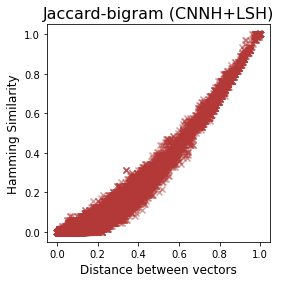

In [42]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Distance between vectors", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Jaccard-bigram (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/Jaccard-bigram-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [43]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [44]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)

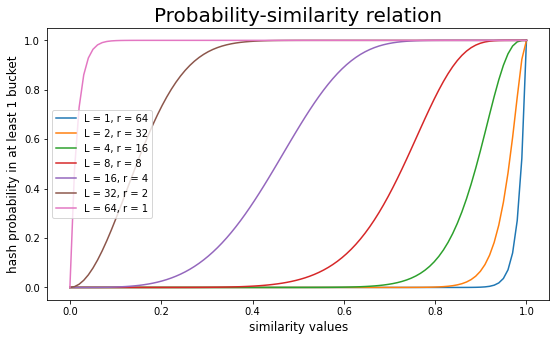

In [45]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 20)
plt.legend()

In [46]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Jaccard-bigram', trace = False)

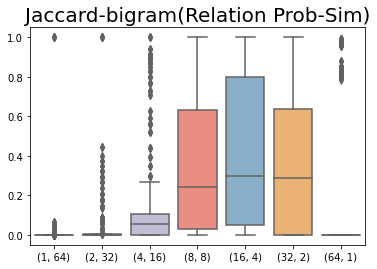

In [47]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.title('Jaccard-bigram(Relation Prob-Sim)', fontsize = 20)
plt.savefig('Results/Baseline/Jaccard-bigram-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [48]:
'L = K = 8'
L, K = params[3]
L, K

(8, 8)

### 4.1.1 Mean and Median probability for all stack traces for the best combination of $K$ and $L$

In [49]:
df_probLSH.mean()['(8, 8)']

0.3579532676717991

In [50]:
df_probLSH.median()['(8, 8)']

0.24143042452110408

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [51]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [52]:
with open('Hash-Tables/hash_tables_baseline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [53]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

615

In [54]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{141, 366, 373, 576, 615, 719, 814, 848, 934}

In [55]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [56]:
near_duplicates_sim = df_measures['Jaccard-bigram'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

425898    0.928571
303490    0.750000
409862    0.687500
299087    0.687500
425812    0.687500
425683    0.625000
425778    0.625000
131462    0.588235
Name: Jaccard-bigram, dtype: float64

In [57]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Jaccard-bigram', n_stacks, n_duplicate_pairs)
set_real_nns

{179, 311, 366, 373, 524, 576, 891, 934}

In [58]:
real_nns_sim[:n_duplicate_pairs]

425898    0.928571
303490    0.750000
386540    0.750000
163325    0.687500
425855    0.687500
299087    0.687500
262787    0.687500
409862    0.687500
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [58]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.674

In [59]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.7938650306748466

-----------------------------------------------------------------

In [60]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.7366666666666679

In [61]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.8692946058091283

-----------------------------------------------------------------

In [62]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.7572000000000005

In [63]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.9248322147651011

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [64]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

1.0

In [65]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard-bigram', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.842757
(2, 32)    0.844779
(4, 16)    0.851347
(8, 8)     0.821027
(16, 4)    0.757519
(32, 2)    0.719732
(64, 1)    0.873365
dtype: float64

In [66]:
df_knns.mean()['(8, 8)']

0.8210268162626742

### 4.4.3. Recall w.r.t. LSH

In [59]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard-bigram', trace = False)
df_recall.mean(skipna = True)

(1, 64)    1.000000
(2, 32)    1.000000
(4, 16)    0.789493
(8, 8)     0.698668
(16, 4)    0.670635
(32, 2)    0.447298
(64, 1)    0.540953
dtype: float64

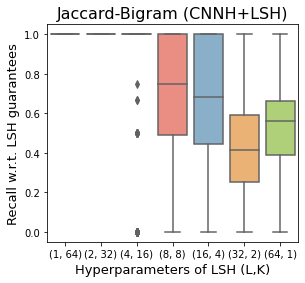

In [67]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('Jaccard-Bigram (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precison w.r.t. LSH

In [61]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard-bigram', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.013951
(2, 32)    0.013139
(4, 16)    0.163588
(8, 8)     0.559774
(16, 4)    0.683929
(32, 2)    0.774739
(64, 1)    0.778712
dtype: float64

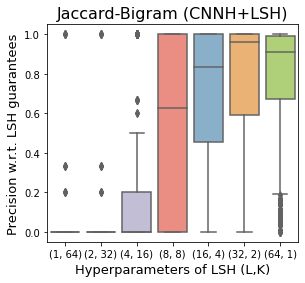

In [68]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('Jaccard-Bigram (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/Precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [63]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.016009
(2, 32)    0.015078
(4, 16)    0.181332
(8, 8)     0.500238
(16, 4)    0.599106
(32, 2)    0.501702
(64, 1)    0.594707
dtype: float64

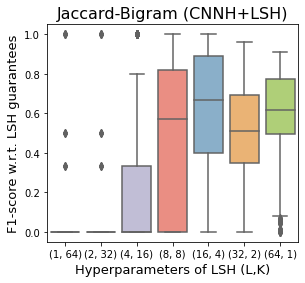

In [64]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('Jaccard-Bigram (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/fscore-LSH', bbox_inches='tight')
plt.show()